<a href="https://colab.research.google.com/github/saavedramarcosdavid/Aprendizaje-de-Maquina/blob/main/Clase3/Clase_3_Clasificaci%C3%B3n_no_param%C3%A9trica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje de máquina - Clase 3

## Ejercicio 1

Supongamos que tenemos un dataset mezcla de dos grupos aleatorios bidimensionales (cada uno con 100 datos, su centroide y covariancia).
**Tip**: reutilizar el código de la NB que vimos para outliers.

Encontrar un clasificador por K-NN y evaluar exactitud, precisión, f-measure. Tomar inicialmente un dataset de entrenamiento de N=100 (50+50), k=10, y validar con el resto del dataset. Hacer algunos experimentos con otros N y k, y también cambiando centroide y covariancia de las clases.

**Optativo**: Cambia mucho si el dataset tiene más dimensiones?

### Funciones para la creación y visualización de Datasets

In [ ]:
import time 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def generate_dataset(dataset,features_number, N, mean=None, std=None):
    '''
        generate_dataset
            Funcion para la generacion de un dataset de una clase particular
            con features_number cantidad de columnas
    '''
    np.random.seed()

    if mean is None:
        mean = np.random.randint(0, 10)

    if std is None:
        std = np.random.uniform(0, 10)
    
    df = pd.DataFrame(np.random.normal(loc=mean, scale=std, size=(N, features_number)),
                            columns=['feature{}'.format(i) for i in range(features_number)])

    df['dataset'] = np.full(N, dataset) 
    return df

def df_flatten(df_A, df_B, N):
    '''
        df_flatten
            Une dos dataframes de clases distintas en uno solo
    '''
    if (df_A.columns == df_B.columns).all():
        nombresA = np.full(N, 'A')
        nombresB = np.full(N, 'B')
        dataset = np.append(nombresA, nombresB)
        df = pd.DataFrame({'dataset': dataset})

        features = []
        for i in range(len(df_A.columns)):
            column = df_A.columns[i]
            feature = np.append(df_A[column], df_B[column])
            df[column] = feature
    else:
        raise "Error"

    return df

def plot_dataset(df):
    '''
        plot_dataset
            funcion para el grafico de dispersion y distribucion de los datos df
    '''
    pp = sns.pairplot(df, hue="dataset")
    pp.fig.suptitle("Dispersión")
    pp.fig.subplots_adjust(top=0.9)
    plt.show()

### Generación y visualización del dataset

In [ ]:
from sklearn.utils import shuffle

features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N)
df_B = generate_dataset('B', features_number, N)
df = shuffle(df_flatten(df_A, df_B, N))

df.head()

,dataset,feature0,feature1
53,A,17.982238,1.058163
187,B,9.836528,6.060514
130,B,11.605126,8.319782
0,A,2.506716,7.259346
107,B,19.881264,10.446724


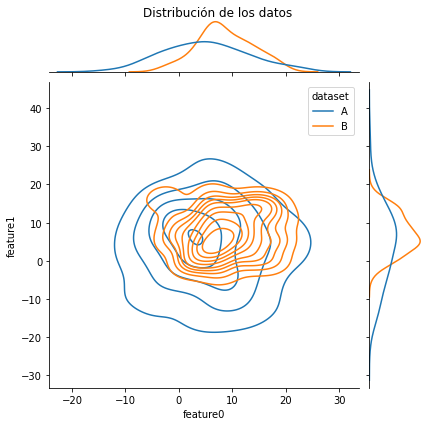

In [ ]:
jp = sns.jointplot(data=df, x='feature0', y='feature1', hue="dataset", kind="kde")
jp.fig.suptitle("Distribución de los datos")
jp.fig.subplots_adjust(top=0.95)
plt.show()

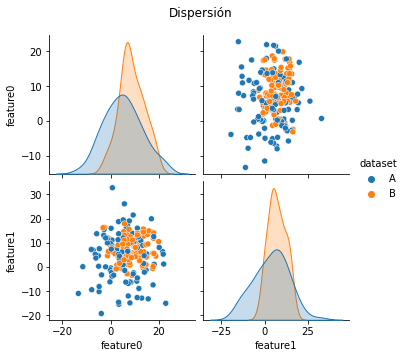

In [ ]:
plot_dataset(df)

### Clasificación no paramétrica utilizando K vecinos más cercanos

#### División en datos de entrenamiento y validación

Se utiliza train_test_split para la división del dataset en datos de entrenamiento y testeo. La división es estratificada para mantener una misma proporción de elementos de una clase en el conjunto.

In [ ]:
from sklearn.model_selection import train_test_split

def dataset_split(df, porcentaje_entrenamiento = 50, porcentaje_testeo = 50):
    '''
        dataset_split
            Divide un dataset (df) en entrenamiento y test segun porcentajes 
            pasados por parámetros
    '''
    total = df.shape[0]
    test_size = porcentaje_testeo/100
    x_train, x_test, y_train, y_test = train_test_split(df.drop('dataset', axis=1).values, df['dataset'].values, 
                                                       test_size=test_size, shuffle=True, stratify=df['dataset'].values)

    print(f"Datos de entrenamiento: {y_train.shape[0]} ({porcentaje_entrenamiento}%)")
    print(f"Datos de testeo: {y_test.shape[0]} ({porcentaje_testeo}%)")

    return x_train, x_test, y_train, y_test

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


#### K vecinos más cercanos

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

k = 10
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

#### Funciones para la evaluación de modelos

*Nota:* funcion desarrollada para el TP2.

In [ ]:
from sklearn.metrics import confusion_matrix

def print_params(real, pred, plot_confusion_matrix = False):
    '''
        print_params:
            Función que calcula e imprime todos los parámetros de calidad.
            Grafica la matriz de confusión generada de la comparación de los valores
            reales y la clasificación realizada en pred.
    '''
    mc = confusion_matrix(real, pred)
    tp, fn, fp, tn = mc.flatten()
    
    tpr = tp / (tp + fn) # de los positivos cuantos se clasificaron positivos (correctos)   -> Sensibilidad o Recall
    tnr = tn / (tn + fp) # de los negativos cuantos se clasificaron negativos (correctos)   -> Especificidad
    fnr = fn / (tp + fn) # de los positivos cuantos se clasificaron negativos (incorrectos) -> 1 - Especificidad
    fpr = fp / (tn + fp) # de los negativos cuantos se clasificaron positivos (incorrectos) -> Fall-out

    ppv = tp / (tp + fp) # de los predichos positivos cuantos realmente eran positivos -> Presicion
    npv = tn / (tn + fn) # de los predichos negativos cuantos realmente eran negativos -> Negative Predictive Value
    fort= fn / (tn + fn) # de los predichos negativos cuantos eran positivos -> False omission Rate
    fdr = fp / (tp + fp) # de los predichos positivos cuantos eran negativos -> False Discovery Rate

    accuracy = (tp + tn)/(tp+fn+tn+fp) # del total cuantos se clasificaron correctamente
    f_measure = (2*ppv*tpr)/(ppv+tpr) # Indica que tan preciso y robusto es el clasificador
    idx_jacard = tp/(tp+fp+fn) # ignorando los tn, proporcion de tp frente a positivos reales y predichos

    report = f"Parámetros de calidad: \n\n"
    report += f"TPR: {tpr:.4f}\tFNR: {fnr:.4f}\nFPR: {fpr:.4f}\tTNR: {tnr:.4f}\n\n"
    report += f"PPV: {ppv:.4f}\tFOR: {fort:.4f}\nFDR: {fdr:.4f}\tNPV: {npv:.4f}\n\n"
    report += f"Accuracy: {accuracy:.4f}\nF_measure: {f_measure:.4f}\nIndice de Jaccard: {idx_jacard:.4f}\n"
    print(report)

    if plot_confusion_matrix:
        df_cm = pd.DataFrame(mc, index = [i for i in "AB"], columns = [i for i in "AB"])
        plt.figure(figsize = (6,5))
        sns.heatmap(df_cm, annot=True)
        plt.title("Matriz de confusión")
        plt.show()

#### Evaluación de parámetros de calidad

Parámetros de calidad: 

TPR: 0.6600	FNR: 0.3400
FPR: 0.3600	TNR: 0.6400

PPV: 0.6471	FOR: 0.3469
FDR: 0.3529	NPV: 0.6531

Accuracy: 0.6500
F_measure: 0.6535
Indice de Jaccard: 0.4853



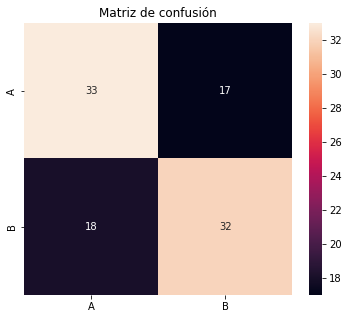

In [ ]:
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

### Prueba con distintos hiperparámetros

#### Utilizando k pequeño

Se realiza la prueba con un _k = 1_.
<hr>
Se puede observar el sobreajuste que se produce con k muy pequeños a partir de las métricas de calidad que resultan extremadamente favorables para el conjunto de entrenamiento y desfavorables para el de testeo. El modelo "recuerda" los datos de entrenamiento pero no generaliza.



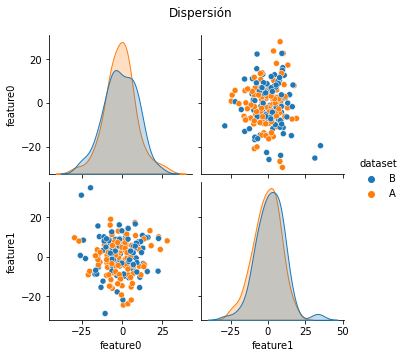

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=0, std=10)
df_B = generate_dataset('B', features_number, N, mean=0, std=10)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


In [ ]:
k = 1
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=1)

Entrenamiento
Parámetros de calidad: 

TPR: 1.0000	FNR: 0.0000
FPR: 0.0000	TNR: 1.0000

PPV: 1.0000	FOR: 0.0000
FDR: 0.0000	NPV: 1.0000

Accuracy: 1.0000
F_measure: 1.0000
Indice de Jaccard: 1.0000



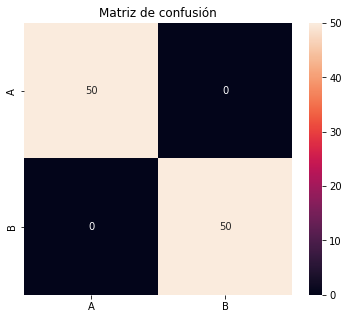

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.4800	FNR: 0.5200
FPR: 0.3800	TNR: 0.6200

PPV: 0.5581	FOR: 0.4561
FDR: 0.4419	NPV: 0.5439

Accuracy: 0.5500
F_measure: 0.5161
Indice de Jaccard: 0.3478



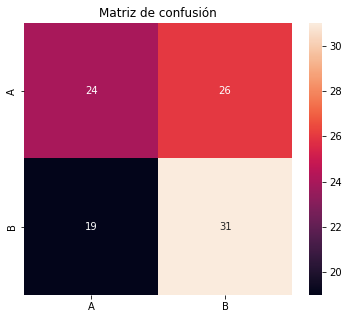

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

#### Utilizando un k grande
Se realiza la prueba con un _k=50_ (k>=N/2).
<hr>
Se presenta una situación de subajuste puesto que el modelo se inclinaría por la clase mayoritaria (aunque en este caso son de cantidades iguales). Por lo que no ajusta correctamente generalizando por demás. 

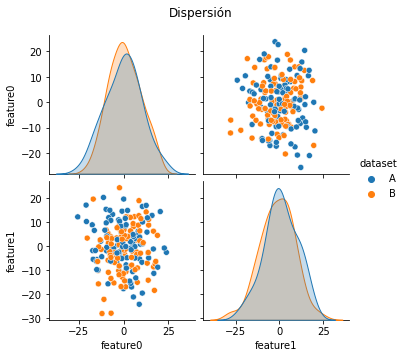

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=0, std=10)
df_B = generate_dataset('B', features_number, N, mean=0, std=10)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


In [ ]:
k = 50
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=50)

Entrenamiento
Parámetros de calidad: 

TPR: 0.3400	FNR: 0.6600
FPR: 0.3000	TNR: 0.7000

PPV: 0.5312	FOR: 0.4853
FDR: 0.4688	NPV: 0.5147

Accuracy: 0.5200
F_measure: 0.4146
Indice de Jaccard: 0.2615



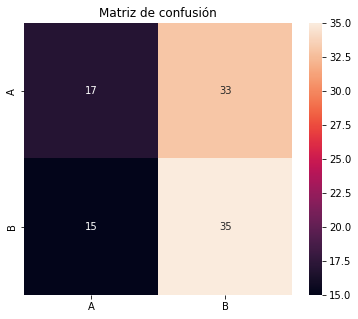

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.3200	FNR: 0.6800
FPR: 0.4200	TNR: 0.5800

PPV: 0.4324	FOR: 0.5397
FDR: 0.5676	NPV: 0.4603

Accuracy: 0.4500
F_measure: 0.3678
Indice de Jaccard: 0.2254



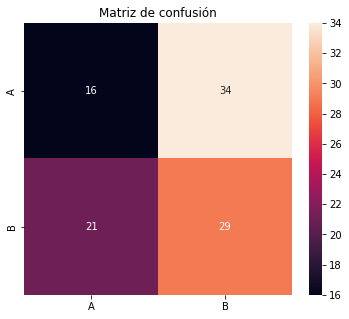

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

#### Utilizando gran parte de los datos para el entrenamiento
En este caso N_entrenamiento = 90%, N_testeo = 10%. _k = sqrt(N_entrenamiento)_.
<hr>
Se suministra al modelo una gran cantidad de datos de entrenamiento, al ser la división de datos proporcional, el modelo puede generalizar correctamente y clasificar los datos de testeo. En este caso incluso obteniendo mejores métricas en testeo.

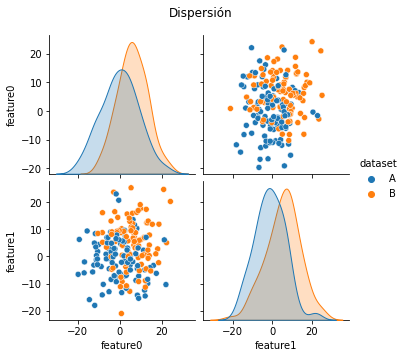

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=0, std=8)
df_B = generate_dataset('B', features_number, N, mean=5, std=8)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
porcentaje_entrenamiento = 90
porcentaje_testeo = 10

x_train, x_test, y_train, y_test = dataset_split(df, porcentaje_entrenamiento, porcentaje_testeo)

Datos de entrenamiento: 180 (90%)
Datos de testeo: 20 (10%)


In [ ]:
k = int(np.sqrt(y_train.shape[0]))
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

Entrenamiento
Parámetros de calidad: 

TPR: 0.7667	FNR: 0.2333
FPR: 0.3222	TNR: 0.6778

PPV: 0.7041	FOR: 0.2561
FDR: 0.2959	NPV: 0.7439

Accuracy: 0.7222
F_measure: 0.7340
Indice de Jaccard: 0.5798



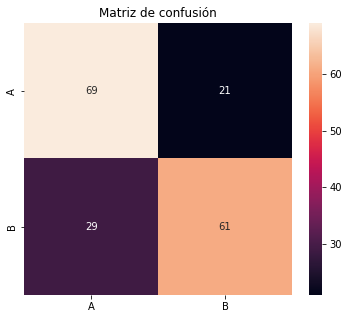

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.8000	FNR: 0.2000
FPR: 0.2000	TNR: 0.8000

PPV: 0.8000	FOR: 0.2000
FDR: 0.2000	NPV: 0.8000

Accuracy: 0.8000
F_measure: 0.8000
Indice de Jaccard: 0.6667



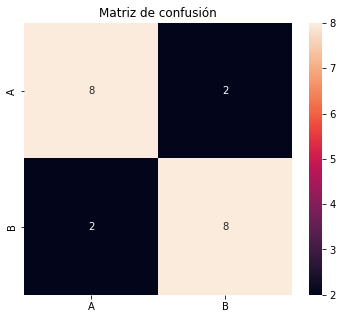

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

#### Utilizando gran parte de los datos para el testeo
En este caso N_entrenamiento = 10%, N_testeo = 90%. k = sqrt(N_entrenamiento).
<hr>
De igual forma que en la prueba anterior, se utiliza el k optimo aproximado siguiendo la regla heurística de la raíz de N. Sin embargo a pesar de contar con un k pequeño, la escasa cantidad de datos de entrenamiento dificulta la clasificación y generalización del modelo.



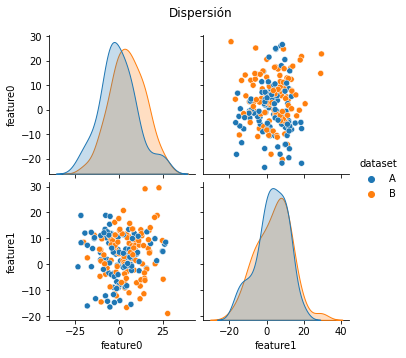

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=0, std=10)
df_B = generate_dataset('B', features_number, N, mean=5, std=10)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
porcentaje_entrenamiento = 10
porcentaje_testeo = 90

x_train, x_test, y_train, y_test = dataset_split(df, porcentaje_entrenamiento, porcentaje_testeo)

Datos de entrenamiento: 20 (10%)
Datos de testeo: 180 (90%)


In [ ]:
k = int(np.sqrt(y_train.shape[0]))
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=4)

Entrenamiento
Parámetros de calidad: 

TPR: 0.9000	FNR: 0.1000
FPR: 0.6000	TNR: 0.4000

PPV: 0.6000	FOR: 0.2000
FDR: 0.4000	NPV: 0.8000

Accuracy: 0.6500
F_measure: 0.7200
Indice de Jaccard: 0.5625



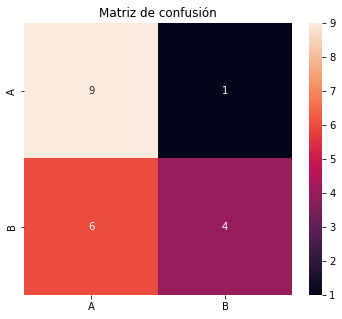

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.8111	FNR: 0.1889
FPR: 0.6778	TNR: 0.3222

PPV: 0.5448	FOR: 0.3696
FDR: 0.4552	NPV: 0.6304

Accuracy: 0.5667
F_measure: 0.6518
Indice de Jaccard: 0.4834



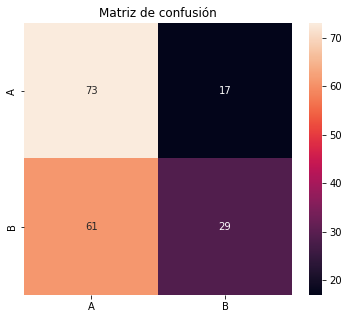

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

#### Alejando los centroides
El centroide de la clase A se ubica en (-10, -10) mientras que el de la B en (10, 10)
<hr>
Al estar los centroides alejados es posible clasificar correctamente gran cantidad de los ejemplos tanto en entrenamiento como en validación. 

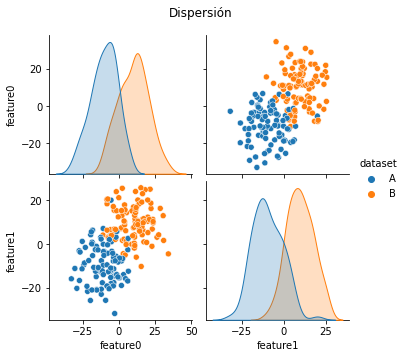

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=-10, std=10)
df_B = generate_dataset('B', features_number, N, mean=10, std=10)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


In [ ]:
k = int(np.sqrt(y_train.shape[0]))
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Entrenamiento
Parámetros de calidad: 

TPR: 0.9800	FNR: 0.0200
FPR: 0.0600	TNR: 0.9400

PPV: 0.9423	FOR: 0.0208
FDR: 0.0577	NPV: 0.9792

Accuracy: 0.9600
F_measure: 0.9608
Indice de Jaccard: 0.9245



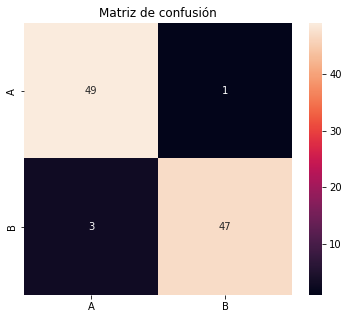

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.9000	FNR: 0.1000
FPR: 0.0600	TNR: 0.9400

PPV: 0.9375	FOR: 0.0962
FDR: 0.0625	NPV: 0.9038

Accuracy: 0.9200
F_measure: 0.9184
Indice de Jaccard: 0.8491



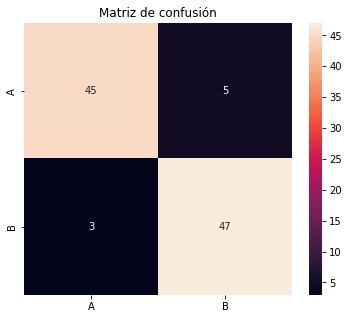

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

#### Acercando centroides
Ambos centroides se ubican en (0, 0) con una covarianza similar, existiendo una gran superposición de los datos.
<hr>
Dicha superposición de datos dificulta la clasificación, por lo que el modelo no obtiene buenas métricas de calidad.

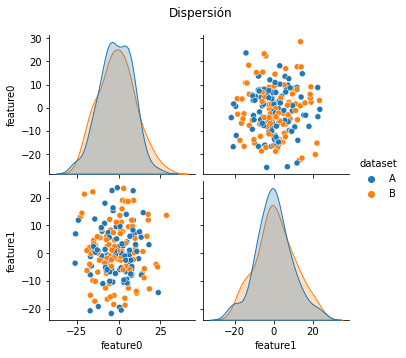

In [ ]:
features_number = 2
N = 100
df_A = generate_dataset('A', features_number, N, mean=0, std=10)
df_B = generate_dataset('B', features_number, N, mean=0, std=10)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


In [ ]:
k = int(np.sqrt(y_train.shape[0]))
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Entrenamiento
Parámetros de calidad: 

TPR: 0.7000	FNR: 0.3000
FPR: 0.5800	TNR: 0.4200

PPV: 0.5469	FOR: 0.4167
FDR: 0.4531	NPV: 0.5833

Accuracy: 0.5600
F_measure: 0.6140
Indice de Jaccard: 0.4430



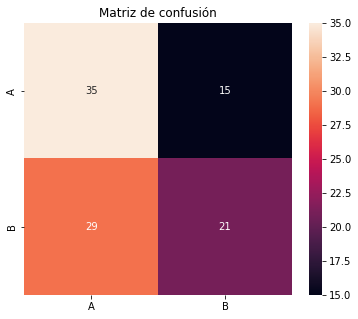

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.6000	FNR: 0.4000
FPR: 0.8000	TNR: 0.2000

PPV: 0.4286	FOR: 0.6667
FDR: 0.5714	NPV: 0.3333

Accuracy: 0.4000
F_measure: 0.5000
Indice de Jaccard: 0.3333



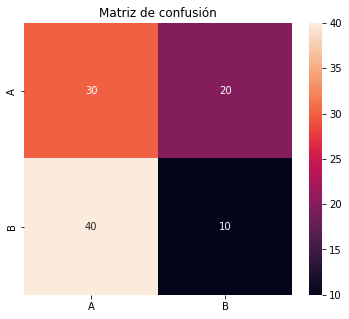

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

### Dataset con más dimensiones
El flujo de trabajo no varía, k vecinos más cercanos está preparado para calcular las distancias (como medida de similitud) por más que no los datos no se puedan graficar y observar visualmente (más de dos clases). Incluso, en este caso, se obtiene un modelo bastante robusto y efectivo con parámetros en validación y entrenamiento similares.

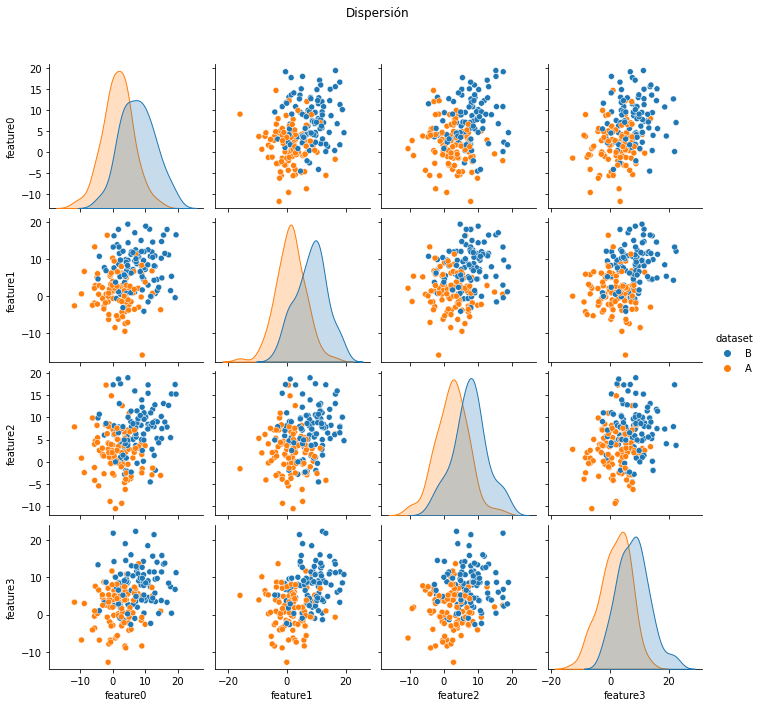

In [ ]:
features_number = 4
N = 100
df_A = generate_dataset('A', features_number, N, mean=2, std=5)
df_B = generate_dataset('B', features_number, N, mean=8, std=5)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)

In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df)

Datos de entrenamiento: 100 (50%)
Datos de testeo: 100 (50%)


In [ ]:
k = 10
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10)

Entrenamiento
Parámetros de calidad: 

TPR: 0.9600	FNR: 0.0400
FPR: 0.2800	TNR: 0.7200

PPV: 0.7742	FOR: 0.0526
FDR: 0.2258	NPV: 0.9474

Accuracy: 0.8400
F_measure: 0.8571
Indice de Jaccard: 0.7500



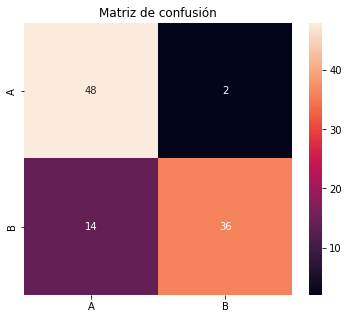

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.8800	FNR: 0.1200
FPR: 0.2200	TNR: 0.7800

PPV: 0.8000	FOR: 0.1333
FDR: 0.2000	NPV: 0.8667

Accuracy: 0.8300
F_measure: 0.8381
Indice de Jaccard: 0.7213



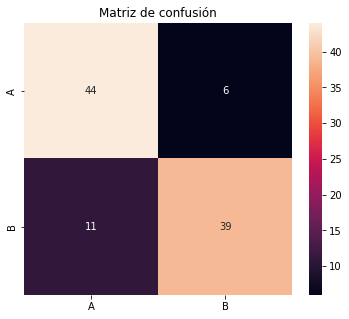

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)

## Ejercicio 2

Hacer alguna experiencia con el dataset anterior utilizando validáción cruzada
y (o) grid search.

### Creación del dataset
Se incorpora diferencia en media y desviacion standard para features

In [ ]:
def generate_dataset_params(dataset,features_number, N, means=None, stds=None):
    '''
        generate_dataset_params
            Funcion para la generacion de un dataset de una clase particular con 
            features_number cantidad de columnas y means|stds distintas por features
    '''
    np.random.seed()

    if means is None:
        means = []
        for i in range(features_number):
            means.append(np.random.randint(0, 10))

    if stds is None:
        stds = []
        for i in range(features_number):
            stds.append(np.random.randint(2, 8))
    
    df = pd.DataFrame()

    for i in range(features_number):
        df['feature{}'.format(i)] = np.random.normal(loc=means[i], scale=stds[i], size=(N,))

    df['dataset'] = np.full(N, dataset) 
    return df

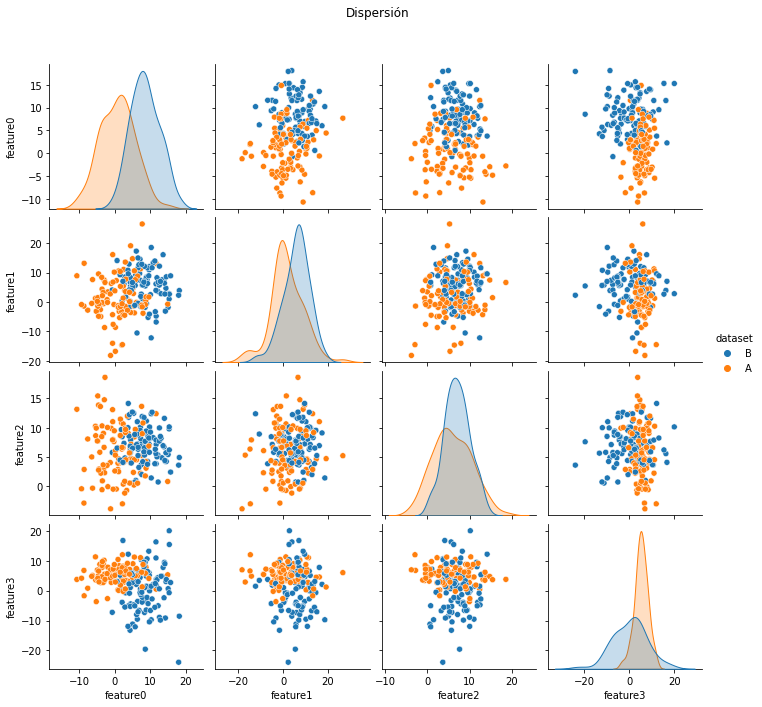

,feature0,feature1,feature2,feature3
count,200.000000,200.000000,200.000000,200.000000
mean,4.570675,3.772299,6.439787,2.763580
std,5.916977,6.889571,3.859791,6.312880
min,-10.725560,-18.197496,-3.807641,-23.938549
25%,0.833332,-0.843004,4.006825,0.216359
50%,4.741191,3.888953,6.450468,3.920064
75%,8.697626,8.419788,9.010154,6.526755
max,18.102675,26.576631,18.596986,20.023099


In [ ]:
from sklearn.utils import shuffle

features_number = 4
N = 100
df_A = generate_dataset_params('A', features_number, N)
df_B = generate_dataset_params('B', features_number, N)
df = shuffle(df_flatten(df_A, df_B, N))

plot_dataset(df)
df.describe()

### [Validación cruzada (KFold)](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

x = df.drop('dataset', axis=1).values
y = df['dataset'].values

n_splits = 5
kf = KFold(n_splits)
print(kf)

total = 2*N
testeo = total//n_splits
entrenamiento = total-testeo
k = int(np.sqrt(entrenamiento))

print(f"Datos de entrenamiento: {entrenamiento}")
print(f"Datos de testeo: {testeo}")
print(f"K optimo: {k}\n")

i=0
acc_promedio_train = 0
acc_promedio_test = 0
acc_max_test = 0
for train_index, test_index in kf.split(x):
    i+=1
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    k = int(np.sqrt(x_train.shape[0]))
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)

    print("-"*15 + "Bloque "+str(i) + "-"*15)
    print("Entrenamiento")
    y_pred = knn_model.predict(x_train)
    print_params(y_train, y_pred, plot_confusion_matrix = False)
    acc = knn_model.score(x_train, y_train)
    acc_promedio_train += acc
    
    print("Validacion")
    y_pred = knn_model.predict(x_test)
    print_params(y_test, y_pred, plot_confusion_matrix = False)
    acc = knn_model.score(x_test, y_test)
    acc_promedio_test += acc
    if acc > acc_max_test:
        acc_max_test = acc
        mejor_modelo = knn_model

acc_promedio_train /= n_splits
acc_promedio_test /= n_splits

KFold(n_splits=5, random_state=None, shuffle=False)
Datos de entrenamiento: 160
Datos de testeo: 40
K optimo: 12

---------------Bloque 1---------------
Entrenamiento
Parámetros de calidad: 

TPR: 0.9277	FNR: 0.0723
FPR: 0.2338	TNR: 0.7662

PPV: 0.8105	FOR: 0.0923
FDR: 0.1895	NPV: 0.9077

Accuracy: 0.8500
F_measure: 0.8652
Indice de Jaccard: 0.7624

Validacion
Parámetros de calidad: 

TPR: 0.8824	FNR: 0.1176
FPR: 0.1739	TNR: 0.8261

PPV: 0.7895	FOR: 0.0952
FDR: 0.2105	NPV: 0.9048

Accuracy: 0.8500
F_measure: 0.8333
Indice de Jaccard: 0.7143

---------------Bloque 2---------------
Entrenamiento
Parámetros de calidad: 

TPR: 0.9259	FNR: 0.0741
FPR: 0.1772	TNR: 0.8228

PPV: 0.8427	FOR: 0.0845
FDR: 0.1573	NPV: 0.9155

Accuracy: 0.8750
F_measure: 0.8824
Indice de Jaccard: 0.7895

Validacion
Parámetros de calidad: 

TPR: 0.7895	FNR: 0.2105
FPR: 0.0952	TNR: 0.9048

PPV: 0.8824	FOR: 0.1739
FDR: 0.1176	NPV: 0.8261

Accuracy: 0.8500
F_measure: 0.8333
Indice de Jaccard: 0.7143

---------------Blo

In [ ]:
print(f"Accuracy promedio en entrenamiento: {acc_promedio_train:.4f}")
print(f"Accuracy promedio en validacion: {acc_promedio_test:.4f}")
print(f'Mejor resultado obtenido con {acc_max_test:.4f} de accuracy en test: {mejor_modelo}')

Accuracy promedio en entrenamiento: 0.8662
Accuracy promedio en validacion: 0.8550
Mejor resultado obtenido con 0.9250 de accuracy en test: KNeighborsClassifier(n_neighbors=12)


**Conclusión:** el modelo adoptado obtiene un Accuracy de aproximadamente 86%, lo que quiere decir que logra clasificar correctamente gran cantidad de los elementos del dataset. 

Si bien no se extrae el valor F promedio, se puede ver que obtiene valores mayores a 0.8 en todos los bloques. Por lo que es un modelo equilibrado. 

El uso de la validación cruzada tambien permite ver si en alguno de los bloques los resultados son muy desfavorables, a partir de lo cual se podría inferir que el modelo tiene problema para clasificar ciertos datos. En este caso particular no sucede en ningun bloque.

### [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
x, y = df.drop('dataset', axis=1).values, df['dataset'].values

In [ ]:
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
k_range = list(range(1, 50))
param_grid = dict(n_neighbors=k_range)
  
grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=False,verbose=3)
grid_search=grid.fit(x, y)

Fitting 5 folds for each of 49 candidates, totalling 245 fits
[CV 1/5] END .....................n_neighbors=1;, score=0.825 total time=   0.0s
[CV 2/5] END .....................n_neighbors=1;, score=0.800 total time=   0.0s
[CV 3/5] END .....................n_neighbors=1;, score=0.925 total time=   0.0s
[CV 4/5] END .....................n_neighbors=1;, score=0.750 total time=   0.0s
[CV 5/5] END .....................n_neighbors=1;, score=0.800 total time=   0.0s
[CV 1/5] END .....................n_neighbors=2;, score=0.800 total time=   0.0s
[CV 2/5] END .....................n_neighbors=2;, score=0.800 total time=   0.0s
[CV 3/5] END .....................n_neighbors=2;, score=0.950 total time=   0.0s
[CV 4/5] END .....................n_neighbors=2;, score=0.750 total time=   0.0s
[CV 5/5] END .....................n_neighbors=2;, score=0.775 total time=   0.0s
[CV 1/5] END .....................n_neighbors=3;, score=0.800 total time=   0.0s
[CV 2/5] END .....................n_neighbors=3

In [ ]:
mejor_modelo = KNeighborsClassifier(grid_search.best_params_['n_neighbors'])
mejor_modelo.fit(x_train, y_train)
print(f'Mejor modelo obtenido: {mejor_modelo}')
print(f'=> Accuracy promedio en entrenamiento Grid: {grid_search.best_score_:.4f}')

Mejor modelo obtenido: KNeighborsClassifier(n_neighbors=7)
=> Accuracy promedio en entrenamiento Grid: 0.8850


**Conclusión:** GridSearchCV permite automatizar la búsqueda de hiperparámetros de manera eficiente, incluso indicando en qué cantidad de bloques se desea hacer la validación cruzada. En este caso se ha determinado que el mejor clasificador de K vecinos más cercanos es aquel que tiene k = 7 probando valores de k desde 1 hasta 50.

## Ejercicio 3

En el notebook [musica.ipynb](https://github.com/manlio99/Materia-de-aprendizaje/blob/master/3_MidtermProjects/musica.ipynb) hay un dataset con 2000+ canciones de
Spotify de una usuaria, donde algunas fueron marcadas como gustadas y otras
no. Cada canción tiene a su vez 16 atributos (nombre, artista, duración,
bailable, etc.). Desarrollar un clasificador que prediga si una canción dada va a ser gustada o no. Aclarar y justificar los pasos, analizar y explicar los resultados.

### Carga y curado del dataset

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectBOM/data/attributes_spotify.csv",index_col=[0])
df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


#### Analizar información del dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  song_title        2017 non-null   object 
 15  artist            2017 non-null   object 
dtypes: float64(10), int64(4), object(2)
memory

In [ ]:
df.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,2017.000000,2017.000000,2.017000e+03,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mean,0.187590,0.618422,2.463062e+05,0.681577,0.133286,5.342588,0.190844,-7.085624,0.612295,0.092664,121.603272,3.968270,0.496815,0.505702
std,0.259989,0.161029,8.198181e+04,0.210273,0.273162,3.648240,0.155453,3.761684,0.487347,0.089931,26.685604,0.255853,0.247195,0.500091
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800,0.000000
25%,0.009630,0.514000,2.000150e+05,0.563000,0.000000,2.000000,0.092300,-8.394000,0.000000,0.037500,100.189000,4.000000,0.295000,0.000000
50%,0.063300,0.631000,2.292610e+05,0.715000,0.000076,6.000000,0.127000,-6.248000,1.000000,0.054900,121.427000,4.000000,0.492000,1.000000
75%,0.265000,0.738000,2.703330e+05,0.846000,0.054000,9.000000,0.247000,-4.746000,1.000000,0.108000,137.849000,4.000000,0.691000,1.000000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


#### Suprimir columnas que no tienen interés

Se analizará el contenido de las columnas no numéricas.

Como el campo *song_title* tiene una gran cantidad de datos únicos (prácticamente todos), no suma al análisis. Además que en el contexto del problema no tiene relevancia incluir este campo.

In [ ]:
print("Cantidad de titulos distintos:", df.song_title.unique().shape[0])

Cantidad de titulos distintos: 1956


In [ ]:
df = df.drop('song_title', axis = 1)

Si bien hay muchos artistas, puede que tenga relevancia en este problema considerar este dato. Por lo que se cuantizará con valor entero. No se codificará con multiples campos puesto que aumentaría la dimensionalidad en gran medida.

In [ ]:
print("Cantidad de artistas:", df.artist.unique().shape[0])

Cantidad de artistas: 1343


In [ ]:
df.artist = pd.factorize(df.artist)[0]

Resultado: 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2017 entries, 0 to 2016
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2017 non-null   float64
 1   danceability      2017 non-null   float64
 2   duration_ms       2017 non-null   int64  
 3   energy            2017 non-null   float64
 4   instrumentalness  2017 non-null   float64
 5   key               2017 non-null   int64  
 6   liveness          2017 non-null   float64
 7   loudness          2017 non-null   float64
 8   mode              2017 non-null   int64  
 9   speechiness       2017 non-null   float64
 10  tempo             2017 non-null   float64
 11  time_signature    2017 non-null   float64
 12  valence           2017 non-null   float64
 13  target            2017 non-null   int64  
 14  artist            2017 non-null   int64  
dtypes: float64(10), int64(5)
memory usage: 252.1 KB


#### Suprimir filas con datos erroneos

In [ ]:
def eliminar_atipicos(y, column):
    # Calcular rango intercuartil
    y_df = pd.DataFrame({'y': y})

    q25, q75 = np.percentile(y_df['y'], 25), np.percentile(y_df['y'], 75)
    iqr = q75 - q25

    # Calcule el rango de valores atípicos
    k = 1.5
    range_ir = iqr * k

    # Límites
    lower_bound_ir, upper_bound_ir = q25 - range_ir, q75 + range_ir

    # Creacion de mascaras y busqueda de atípicos y no atípicos
    outliers_mask_ir = [True if x < lower_bound_ir or x > upper_bound_ir else False for x in y_df['y']]
    no_outliers_mask_ir = [False if x < lower_bound_ir or x > upper_bound_ir else True for x in y_df['y']]

    outliers = y_df['y'][outliers_mask_ir]
    no_outliers = y_df['y'][no_outliers_mask_ir]

    print(column,outliers.shape)
    # Se devuelve y sin atípicos
    return y[no_outliers_mask_ir]

In [ ]:
for column in df.columns:
    eliminar_atipicos(df[column].values, column)

acousticness (194,)
danceability (12,)
duration_ms (141,)
energy (54,)
instrumentalness (416,)
key (0,)
liveness (126,)
loudness (105,)
mode (0,)
speechiness (209,)
tempo (15,)
time_signature (126,)
valence (0,)
target (0,)
artist (0,)


**Comentario:** No se hace uso de esta estrategia (no se completa la eliminación de ejemplos con valores atípicos, solo se imprimen cantidades) puesto que a pesar de ser un dataset medianamente alto,se perdería demasiada información al eliminar las filas con valores atípicos.

#### Curado de los datos mediante Normalización y Estandarización

##### Gráfico de las distribuciones de los datos

Las columnas que presenten aproximadamente una distribución normal, serán estandarizadas. Mientras que las restantes, serán normalizadas.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def print_hist(data,title, ax):
    '''
        print_hist:
            Función para dibujar el histograma y la distribución de los datos.
    '''
    sns.histplot(data, alpha=0.4, kde=True, ax=ax)
    sns.rugplot(data, color="black", ax=ax)
    
    color = "orange"
    text=f"$\\mu$ = {data.mean():.3f}\n"
    text+=f"$\\sigma$ = {data.std(ddof=1):.3f}"

    bbox = dict(boxstyle='round', fc=color, ec=color, alpha=0.3)
    ax.text(0.72, 0.8, text, fontsize=11, bbox=bbox, transform=ax.transAxes)
    ax.set_title(title)

def print_dataset(df, fig_rows, fig_cols):
    '''
        print_dataset:
            Recibe un DataFrame, dibuja sus distribuciones de datos y cuenta cuántos tienen distribución normal
    '''
    cols = df.columns
    fig, axes = plt.subplots(fig_rows, fig_cols, figsize=((fig_cols*25)//5, (fig_rows*8)//2))
    axes = axes.ravel()

    for col_name, ax in zip(cols, axes):
        print_hist(df[col_name],"Distribución de " + col_name, ax)

    fig.tight_layout()
    plt.show()

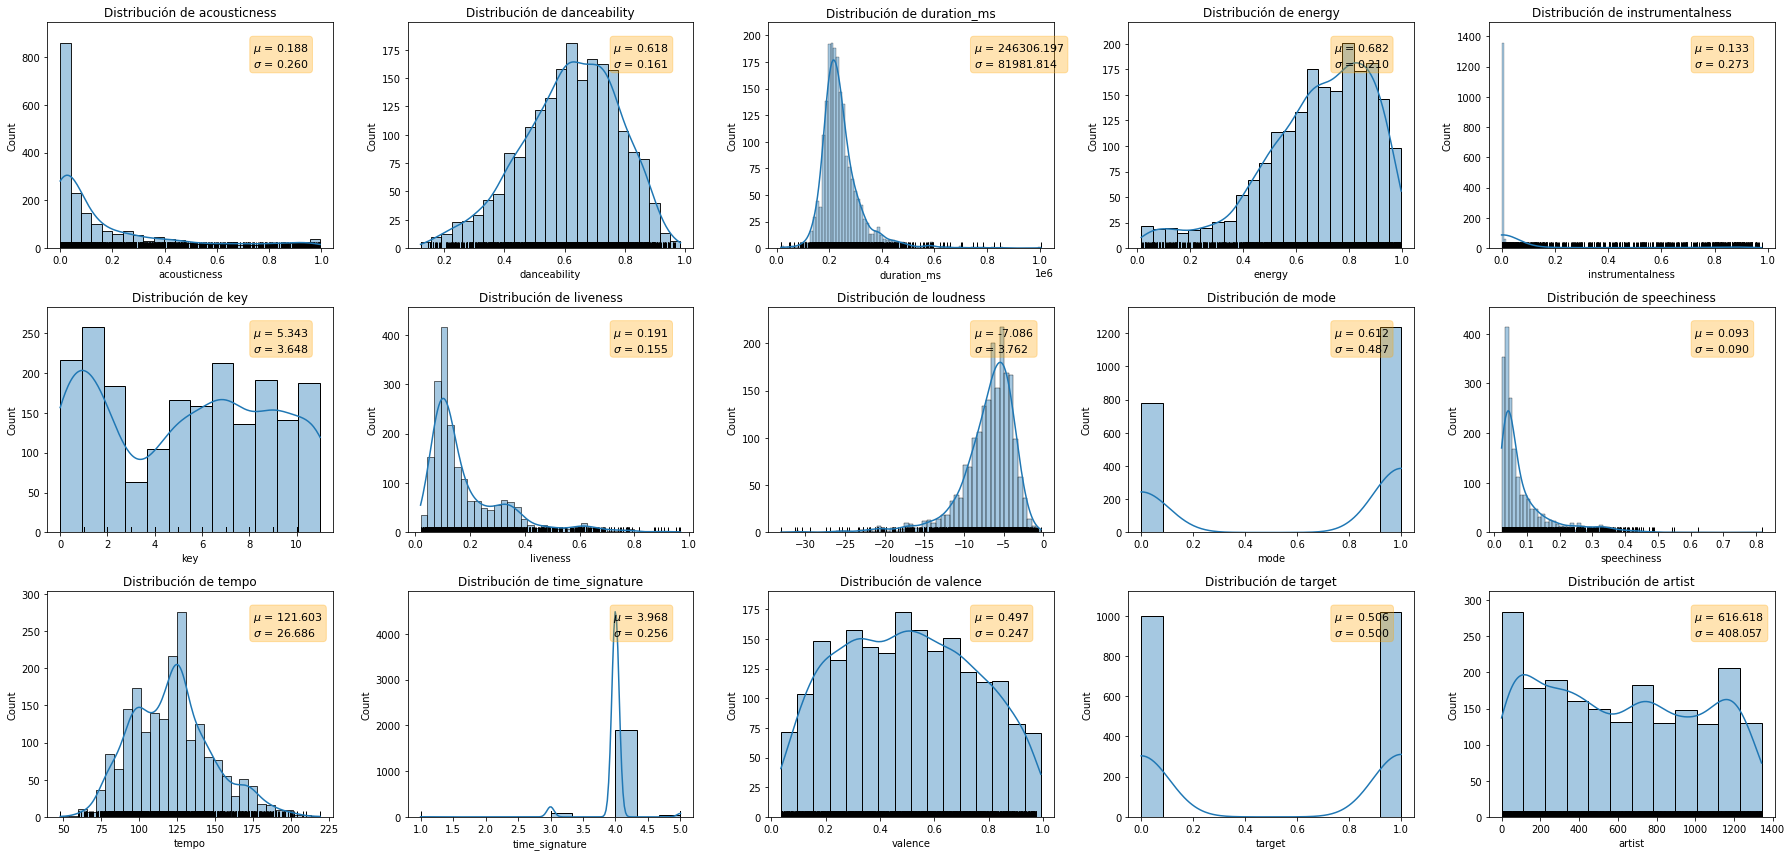

In [ ]:
print_dataset(df, 3, 5)

##### Estandarización
Las siguientes variables tienen visualmente una distribución normal:
* danceability
* duration_ms
* liveness
* loudness
* tempo

In [ ]:
col_norm = ['danceability', 'duration_ms', 'liveness', 'loudness', 'tempo'] 

In [ ]:
def estandarizacion(x):
    x_mean= x.mean()
    x_std= x.std()
    
    x = (x-x_mean)/x_std
    return x

In [ ]:
for col in col_norm:
    df[col] = estandarizacion(df[col])

##### Normalización
Las siguientes variables no tienen visualmente una distribución normal:
* acousticness
* energy
* instrumentalness
* key
* speechiness
* time_signature
* valence
* artist

*Nota:* *target* y *mode* no serán modificados puesto que son valores binarios (0 o 1)

In [ ]:
col_no_norm = df.columns.drop(col_norm).drop(['target', 'mode'])

In [ ]:
def normalizacion(x):
    x = x/x.max()
    return x

In [ ]:
for col in col_no_norm:
    df[col] = normalizacion(df[col])

###Clasificación utilizando k vecinos más cercanos

#### Modelo óptimo

Utilizo GridSearchCV con validación cruzada de 3 bloques para encontrar el k óptimo del algoritmo de k vecinos más cercanos

In [ ]:
x, y = df.drop('target', axis=1).values, df['target'].values

In [ ]:
n_splits = 3
total = y.shape[0]
testeo = total//n_splits
entrenamiento = total-testeo

print(f"Datos de entrenamiento: {entrenamiento}")
print(f"Datos de testeo: {testeo}")

Datos de entrenamiento: 1345
Datos de testeo: 672


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k_range = list(range(1, int(np.sqrt(x_train.shape[0]))))
param_grid = dict(n_neighbors=k_range)
  
grid = GridSearchCV(knn, param_grid, cv=n_splits, scoring='accuracy', return_train_score=False,verbose=3)
grid_search=grid.fit(x_train, y_train)

Fitting 3 folds for each of 39 candidates, totalling 117 fits
[CV 1/3] END .....................n_neighbors=1;, score=0.831 total time=   0.0s
[CV 2/3] END .....................n_neighbors=1;, score=0.803 total time=   0.0s
[CV 3/3] END .....................n_neighbors=1;, score=0.808 total time=   0.1s
[CV 1/3] END .....................n_neighbors=2;, score=0.783 total time=   0.1s
[CV 2/3] END .....................n_neighbors=2;, score=0.771 total time=   0.0s
[CV 3/3] END .....................n_neighbors=2;, score=0.767 total time=   0.0s
[CV 1/3] END .....................n_neighbors=3;, score=0.838 total time=   0.0s
[CV 2/3] END .....................n_neighbors=3;, score=0.822 total time=   0.1s
[CV 3/3] END .....................n_neighbors=3;, score=0.806 total time=   0.1s
[CV 1/3] END .....................n_neighbors=4;, score=0.805 total time=   0.1s
[CV 2/3] END .....................n_neighbors=4;, score=0.796 total time=   0.0s
[CV 3/3] END .....................n_neighbors=4

In [ ]:
k = grid_search.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(k)
print(f'Mejor modelo obtenido: {str(knn_model)}')
print(f'=> Accuracy promedio en entrenamiento Grid: {grid_search.best_score_:.4f}')

Mejor modelo obtenido: KNeighborsClassifier(n_neighbors=7)
=> Accuracy promedio en entrenamiento Grid: 0.8276


#### Evaluación del modelo

Se realiza un split de 80 | 20 para evaluar métricas de calidad del modelo óptimo (k=7).
<hr>

El accuracy obtenido durante la ejecución de GridSearchCV.fit() fue de 82% indicando una moderadamente alta eficacia. 

Para mirar otras métricas de calidad se utiliza la función de gráfico de matriz de confusión y cálculo de métricas anteriormente desarrollado, para analizar el modelo óptimo, obteniendo resultados favorables. El modelo mantuvo un buen equilibrio entre presición y especificidad (dado por la métrica F_measure) y baja proporción de errores.



In [ ]:
x_train, x_test, y_train, y_test = dataset_split(df.rename(columns={"target": "dataset"}),80,20)
knn_model = knn_model.fit(x_train, y_train)

Datos de entrenamiento: 1613 (80%)
Datos de testeo: 404 (20%)


Entrenamiento
Parámetros de calidad: 

TPR: 0.9122	FNR: 0.0878
FPR: 0.1348	TNR: 0.8652

PPV: 0.8686	FOR: 0.0902
FDR: 0.1314	NPV: 0.9098

Accuracy: 0.8884
F_measure: 0.8898
Indice de Jaccard: 0.8015



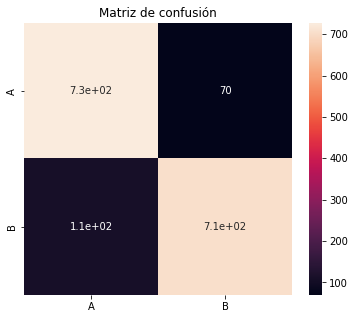

In [ ]:
print("Entrenamiento")
y_pred = knn_model.predict(x_train)
print_params(y_train, y_pred, plot_confusion_matrix = True)

Validacion
Parámetros de calidad: 

TPR: 0.9200	FNR: 0.0800
FPR: 0.2157	TNR: 0.7843

PPV: 0.8070	FOR: 0.0909
FDR: 0.1930	NPV: 0.9091

Accuracy: 0.8515
F_measure: 0.8598
Indice de Jaccard: 0.7541



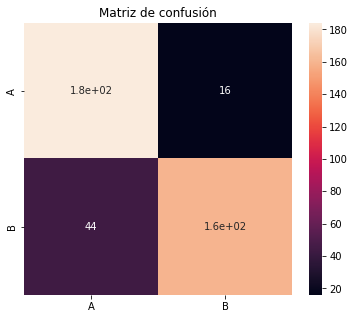

In [ ]:
print("Validacion")
y_pred = knn_model.predict(x_test)
print_params(y_test, y_pred, plot_confusion_matrix = True)